## Reloading dataset and re-encoding features
as in _modeling.ipynb_

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

csv_path = "../data/flights_sample_3m.csv"
df = pd.read_csv(csv_path)

# Similar to what was done in feature_engineering.ipynb

# Feature Engineering: Add temporal features
df["dep_hour"] = df["CRS_DEP_TIME"] // 100

# Extract temporal features from FL_DATE
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['month'] = df['FL_DATE'].dt.month
df['day_of_week'] = df['FL_DATE'].dt.dayofweek  # 0=Monday, 6=Sunday

# Frequency Encoding (can be done before train/test split since it doesn't use target)
# Count how often each airport appears
df["origin_freq"] = df["ORIGIN"].map(df["ORIGIN"].value_counts())
df["dest_freq"] = df["DEST"].map(df["DEST"].value_counts())

# Get proportions
df["origin_freq_proportion"] = df["ORIGIN"].map(df["ORIGIN"].value_counts(normalize=True))
df["dest_freq_proportion"] = df["DEST"].map(df["DEST"].value_counts(normalize=True))

# Drop leakage columns (actual times/delays that happen after scheduled departure)
leakage_cols = [
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
    'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_WEATHER', 'DIVERTED', 'DOT_CODE', 'FL_NUMBER'
]
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

# Separate features and target
X = df.drop(columns=["CANCELLED"])  # Features
y = df["CANCELLED"]  # Target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train):,}")
print(f"Test set size: {len(X_test):,}")
print(f"\nCancellation rate in test set: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")

print("Num features:", X_train.shape[1])
print("Features used:\n", sorted(X_train.columns.tolist()))

Training set size: 2,400,000
Test set size: 600,000

Cancellation rate in test set: 0.0264 (2.64%)
Num features: 20
Features used:
 ['AIRLINE', 'AIRLINE_CODE', 'AIRLINE_DOT', 'CANCELLATION_CODE', 'CRS_ARR_TIME', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DEST', 'DEST_CITY', 'DISTANCE', 'FL_DATE', 'ORIGIN', 'ORIGIN_CITY', 'day_of_week', 'dep_hour', 'dest_freq', 'dest_freq_proportion', 'month', 'origin_freq', 'origin_freq_proportion']


In [43]:
# Preprocessing: Apply target encoding (after train/test split to avoid leakage)
import warnings
warnings.filterwarnings('ignore')

# Make copies for preprocessing
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Target Encoding for AIRLINE (using only training data to avoid leakage)
# Calculate mean cancellation rate per airline from TRAINING data only
if 'AIRLINE' in X_train_processed.columns:
    # Create a temporary dataframe with aligned indices
    temp_df = pd.DataFrame({
        'AIRLINE': X_train_processed['AIRLINE'],
        'CANCELLED': y_train.values
    }, index=X_train_processed.index)
    
    airline_target_means = temp_df.groupby('AIRLINE')['CANCELLED'].mean()
    
    # Apply to both train and test
    X_train_processed['airline_target_encoded'] = X_train_processed['AIRLINE'].map(airline_target_means)
    X_test_processed['airline_target_encoded'] = X_test_processed['AIRLINE'].map(airline_target_means)
    
    # Fill any unseen airlines in test with global training mean
    global_mean = y_train.mean()
    X_test_processed['airline_target_encoded'] = X_test_processed['airline_target_encoded'].fillna(global_mean)
    
    # Also fill any NaN in train (shouldn't happen, but just in case)
    X_train_processed['airline_target_encoded'] = X_train_processed['airline_target_encoded'].fillna(global_mean)
    
    # Drop original AIRLINE column (we have the encoded version)
    X_train_processed = X_train_processed.drop(columns=['AIRLINE'])
    X_test_processed = X_test_processed.drop(columns=['AIRLINE'])

# Select final feature set: use frequency-encoded and target-encoded features
# Drop remaining categorical columns that aren't encoded yet
categorical_cols = X_train_processed.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print(f"Dropping unencoded categorical columns: {categorical_cols}")
    X_train_processed = X_train_processed.drop(columns=categorical_cols)
    X_test_processed = X_test_processed.drop(columns=categorical_cols)

# Drop any columns that shouldn't be used (like CANCELLATION_CODE - only exists for cancelled flights)
columns_to_drop = ['CANCELLATION_CODE'] if 'CANCELLATION_CODE' in X_train_processed.columns else []
if columns_to_drop:
    X_train_processed = X_train_processed.drop(columns=columns_to_drop)
    X_test_processed = X_test_processed.drop(columns=columns_to_drop)

X_train_processed = X_train_processed.drop(columns=['origin_freq', 'dest_freq'])
X_test_processed = X_test_processed.drop(columns=['origin_freq', 'dest_freq'])

# Fill any remaining NaN values with median (for numerical) or 0
# Only fill numeric columns
numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns
X_train_processed[numeric_cols] = X_train_processed[numeric_cols].fillna(X_train_processed[numeric_cols].median())
X_test_processed[numeric_cols] = X_test_processed[numeric_cols].fillna(X_train_processed[numeric_cols].median())

# Ensure all columns are numeric (convert any remaining non-numeric to numeric)
for col in X_train_processed.columns:
    if X_train_processed[col].dtype == 'object':
        # Try to convert to numeric
        X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
        X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')

# Final check: ensure no NaN or infinite values
X_train_processed = X_train_processed.replace([np.inf, -np.inf], np.nan)
X_test_processed = X_test_processed.replace([np.inf, -np.inf], np.nan)
X_train_processed = X_train_processed.fillna(X_train_processed.median())
X_test_processed = X_test_processed.fillna(X_train_processed.median())

# Convert to numpy arrays for sklearn (or keep as DataFrames - sklearn accepts both)
# But ensure all are numeric
X_train_processed = X_train_processed.select_dtypes(include=[np.number])
X_test_processed = X_test_processed.select_dtypes(include=[np.number])

print(f"\nProcessed training shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")
print(f"\nData types: {X_train_processed.dtypes.value_counts().to_dict()}")
print(f"\nAll features being used:")
feature_list = [col for col in X_train_processed.columns]
for feat in feature_list:
    print(f"  - {feat}")

Dropping unencoded categorical columns: ['AIRLINE_DOT', 'AIRLINE_CODE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CANCELLATION_CODE']

Processed training shape: (2400000, 10)
Processed test shape: (600000, 10)

Data types: {dtype('float64'): 5, dtype('int64'): 3, dtype('int32'): 2}

All features being used:
  - CRS_DEP_TIME
  - CRS_ARR_TIME
  - CRS_ELAPSED_TIME
  - DISTANCE
  - dep_hour
  - month
  - day_of_week
  - origin_freq_proportion
  - dest_freq_proportion
  - airline_target_encoded


In [30]:
# Helper function to evaluate models
def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Evaluate model performance and return metrics dictionary"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }
    
    return results


## Random Forest Model

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Using a subset for faster training - can adjust n_estimators and remove sampling for full training
rf_model = RandomForestClassifier(
    n_estimators=100,  # Reduce for faster training; increase for better performance
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=20,  # Limit depth for faster training
    min_samples_split=100,
    min_samples_leaf=50
)

rf_model.fit(X_train_processed, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_processed)
rf_proba = rf_model.predict_proba(X_test_processed)[:, 1]

# Evaluate
print("\nRandom Forest Performance:")

accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, zero_division=0)
recall = recall_score(y_test, rf_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, rf_proba)
pr_auc = average_precision_score(y_test, rf_proba)

results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}

for metric, value in results.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")


Random Forest Performance:
  Accuracy: 0.8270
  Precision: 0.0742
  Recall: 0.4845
  ROC-AUC: 0.7485
  PR-AUC: 0.0862


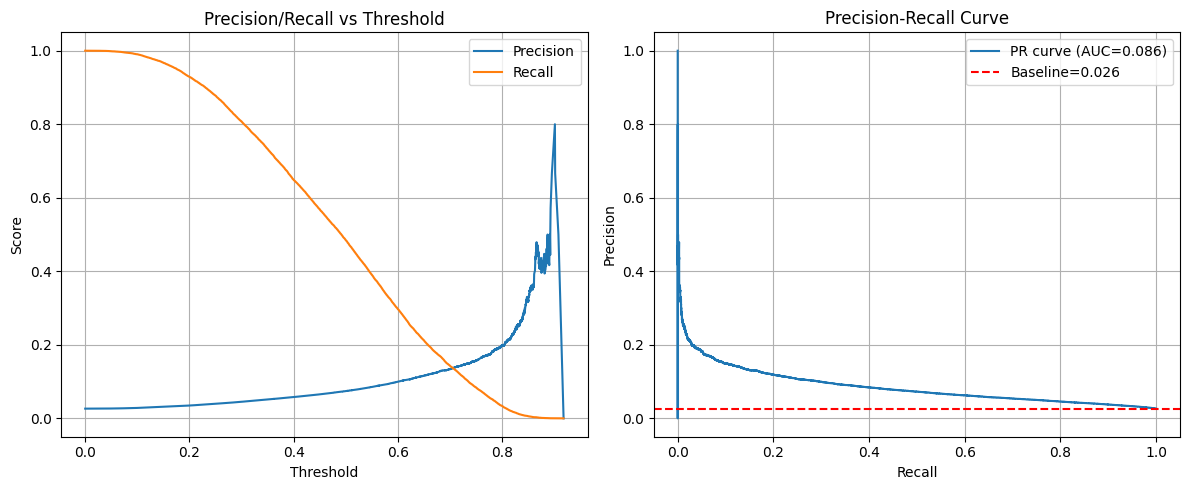

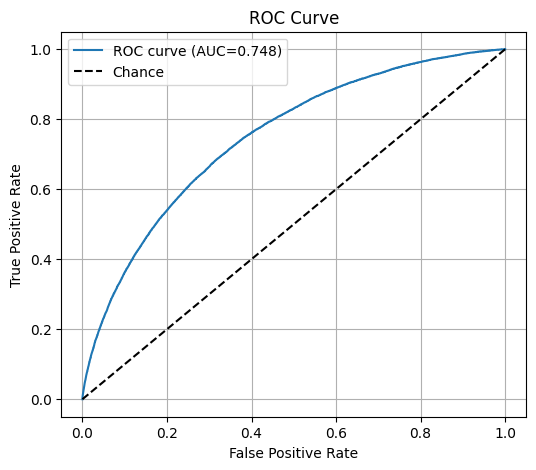

In [45]:
from sklearn.metrics import precision_recall_curve, roc_curve

# From modeling.ipynb
baseline_rate = 0.0264

# Plot Curves
precision, recall, pr_thresholds = precision_recall_curve(y_test, rf_proba)
fpr, tpr, roc_thresholds = roc_curve(y_test, rf_proba)

import matplotlib.pyplot as plt

# Precision / Recall vs Threshold
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(pr_thresholds, precision[:-1], label='Precision')
ax[0].plot(pr_thresholds, recall[:-1], label='Recall')
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Score')
ax[0].set_title('Precision/Recall vs Threshold')
ax[0].legend()
ax[0].grid(True)

# Precision-Recall Curve
ax[1].plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f})')
ax[1].axhline(baseline_rate, color='red', linestyle='--', label=f'Baseline={baseline_rate:.3f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def metrics_at_threshold(th):
    preds = (rf_proba >= th).astype(int)
    return {
        'threshold': th,
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0)
    }

# Different recall targets
recall_target_8 = 0.80

candidates = pd.DataFrame({
    'threshold': pr_thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})
candidates_recall = candidates[candidates['recall'] >= recall_target_8]

if not candidates_recall.empty:
    # Highest threshold that still meets recall target
    best_recall_row = candidates_recall.sort_values('threshold', ascending=False).iloc[0]
    recall_8_th = best_recall_row['threshold']
    recall_8_metrics = metrics_at_threshold(recall_8_th)
else:
    recall_8_th = None
    recall_8_metrics = None

recall_target_9 = 0.90

candidates = pd.DataFrame({
    'threshold': pr_thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})
candidates_recall = candidates[candidates['recall'] >= recall_target_9]

if not candidates_recall.empty:
    # Highest threshold that still meets recall target
    best_recall_row = candidates_recall.sort_values('threshold', ascending=False).iloc[0]
    recall_9_th = best_recall_row['threshold']
    recall_9_metrics = metrics_at_threshold(recall_9_th)
else:
    recall_9_th = None
    recall_9_metrics = None

# High precision target (e.g., >= 0.20)
precision_target = 0.20

candidates_precision = candidates[candidates['precision'] >= precision_target]

if not candidates_precision.empty:
    # FIRST threshold (smallest) that meets precision target
    best_precision_row = candidates_precision.iloc[0]
    high_precision_th = best_precision_row['threshold']
    high_precision_metrics = metrics_at_threshold(high_precision_th)
else:
    high_precision_th = None
    high_precision_metrics = None

# Build a small summary table of the candidate thresholds we selected
summary_rows = []

if recall_8_metrics is not None:
    summary_rows.append({
        'name': f'Recall>={recall_target_8}',
        **recall_8_metrics
    })

if recall_9_metrics is not None:
    summary_rows.append({
        'name': f'Recall>={recall_target_9}',
        **recall_9_metrics
    })

if high_precision_metrics is not None:
    summary_rows.append({
        'name': f'Precision>={precision_target}',
        **high_precision_metrics
    })

summary_df = pd.DataFrame(summary_rows)

print("\nCandidate thresholds:")
if summary_df.empty:
    print("No thresholds satisfied the specified constraints.")
else:
    print(summary_df[['name','threshold','precision','recall']])


Candidate thresholds:
             name  threshold  precision    recall
0     Recall>=0.8   0.309425   0.046035  0.800038
1     Recall>=0.9   0.233092   0.037606  0.900051
2  Precision>=0.2   0.791513   0.200000  0.041003


## Decision making on threshold 

There are two different outcomes, one of which the threshold is to be chosen to optimize for:
- Predicting a flight will be cancelled but it does not
- Predicting a flight will not be cancelled but it does

For this project, I will perceive the latter to be more costly. I like to be prepared for the worst, pessimistic, some might say. Although it could be argued that predicting more false positives could mean spending unnecessary money on rebooking a flight in anticipation, only for that to be of waste as the original flight does not get cancelled eventually, it is highly unlikely for a college student with limited funds like myself to book another flight without actual confirmation of the cancellation. Furthermore, a pleasant surprise is better than an unpleasant one.

Hence, I will proceed with a threshold which places more importance on recall compared to precision.

I decide to find a threshold with **recall >= 0.80 and precision >= 0.045**. Precision remains somewhat important even as I prioritize recall, and this is the range that seems possible based on the thresholds above.

In [46]:
precision_target_45 = 0.045

candidates = pd.DataFrame({
    'threshold': pr_thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})

# Use pandas Series for the & condition
candidates_recall_and_precision = candidates[
    (candidates['recall'] >= recall_target_8) &
    (candidates['precision'] >= precision_target_45)
]

if not candidates_recall_and_precision.empty:
    # Lowest threshold that still meets BOTH constraints
    best_row = candidates_recall_and_precision.iloc[0]
    recall_and_precision_th = best_row['threshold']
    recall_and_precision_metrics = metrics_at_threshold(recall_and_precision_th)
else:
    recall_and_precision_th = None
    recall_and_precision_metrics = None

summary_rows = []

if recall_and_precision_metrics is not None:
    summary_rows.append({
        'name': f'Recall>={recall_target_8} and Precision>={precision_target_45}',
        **recall_and_precision_metrics
    })

summary_df = pd.DataFrame(summary_rows)

print("\nCandidate thresholds:")
if summary_df.empty:
    print("No thresholds satisfied the specified constraints.")
else:
    print(summary_df[['name','threshold','precision','recall']])


Candidate thresholds:
                               name  threshold  precision    recall
0  Recall>=0.8 and Precision>=0.045   0.299231      0.045  0.808251


In [39]:
chosen_th = recall_and_precision_th
y_pred_th = (rf_proba >= chosen_th).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_th).ravel()

precision_final = precision_score(y_test, y_pred_th, zero_division=0)
recall_final = recall_score(y_test, y_pred_th, zero_division=0)

fpr_final = fp / (fp + tn) if (fp + tn) > 0 else np.nan
flagged_rate = (tp + fp) / (tp + fp + tn + fn)

print(f"Chosen threshold: {chosen_th:.6f}")
print(f"Confusion matrix (tn, fp, fn, tp): {tn}, {fp}, {fn}, {tp}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall:    {recall_final:.4f}")
print(f"FPR:       {fpr_final:.4f}")
print(f"% flagged positive: {flagged_rate:.4%}")

Chosen threshold: 0.300752
Confusion matrix (tn, fp, fn, tp): 311318, 272854, 2971, 12857
Precision: 0.0450
Recall:    0.8123
FPR:       0.4671
% flagged positive: 47.6185%


Counts by outcome:
TP     12857
FP    272854
TN    311318
FN      2971
dtype: int64


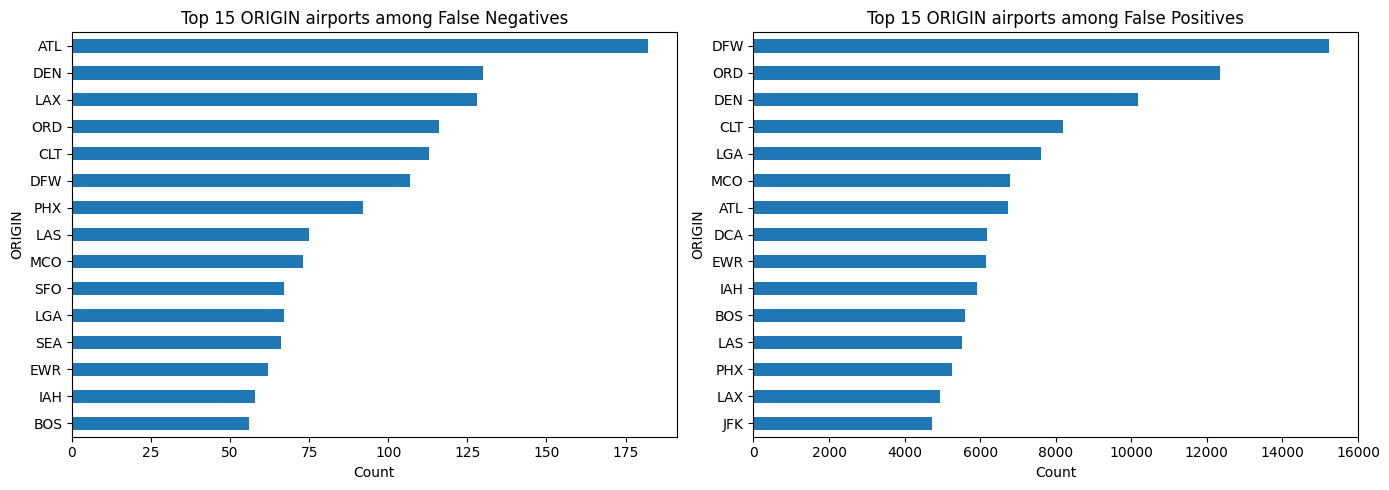

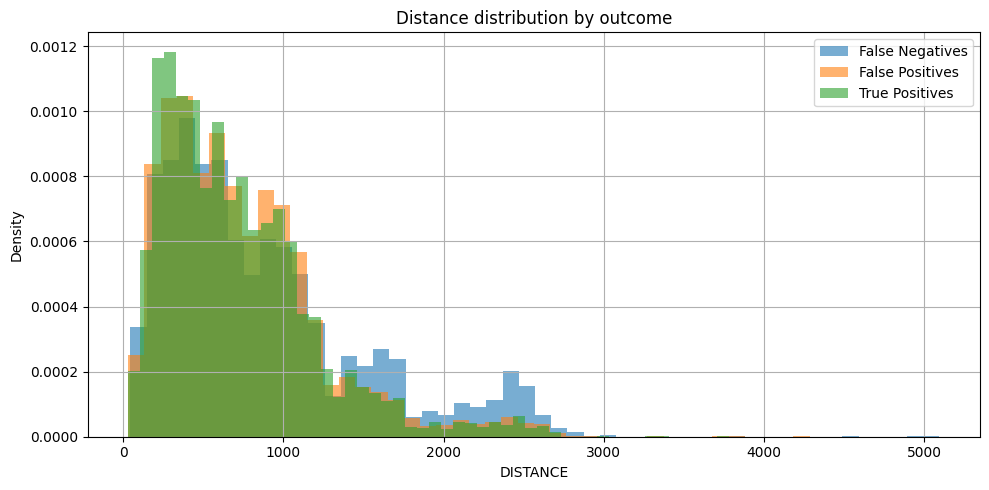

In [47]:
# We'll analyze where the model makes mistakes, e.g. by ORIGIN airport and by DISTANCE.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Build a results dataframe with predictions + key columns for analysis
# X_test here is the preprocessed split *before* dropping categorical columns, so it still contains ORIGIN/DEST/AIRLINE/etc.
analysis_cols = [
    col for col in [
        'AIRLINE', 'ORIGIN', 'DEST', 'ORIGIN_CITY', 'DEST_CITY',
        'DISTANCE', 'dep_hour', 'month', 'day_of_week'
    ] if col in X_test.columns
]

df_results = X_test[analysis_cols].copy()
df_results['y_true'] = y_test.values
df_results['proba_cancel'] = rf_proba
df_results['y_pred'] = y_pred_th

# Error groups
false_negatives = df_results[(df_results['y_true'] == 1) & (df_results['y_pred'] == 0)]
false_positives = df_results[(df_results['y_true'] == 0) & (df_results['y_pred'] == 1)]
true_positives = df_results[(df_results['y_true'] == 1) & (df_results['y_pred'] == 1)]
true_negatives = df_results[(df_results['y_true'] == 0) & (df_results['y_pred'] == 0)]

print('Counts by outcome:')
print(pd.Series({
    'TP': len(true_positives),
    'FP': len(false_positives),
    'TN': len(true_negatives),
    'FN': len(false_negatives),
}))

# --- Plot 1: Top ORIGIN airports for false negatives / false positives ---
if 'ORIGIN' in df_results.columns:
    top_n = 15
    fn_top = false_negatives['ORIGIN'].value_counts().head(top_n)
    fp_top = false_positives['ORIGIN'].value_counts().head(top_n)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    fn_top.sort_values().plot(kind='barh', ax=ax[0])
    ax[0].set_title(f'Top {top_n} ORIGIN airports among False Negatives')
    ax[0].set_xlabel('Count')

    fp_top.sort_values().plot(kind='barh', ax=ax[1])
    ax[1].set_title(f'Top {top_n} ORIGIN airports among False Positives')
    ax[1].set_xlabel('Count')

    plt.tight_layout()
    plt.show()

# --- Plot 2: Distance distribution for errors vs correct positives ---
if 'DISTANCE' in df_results.columns:
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.hist(false_negatives['DISTANCE'].dropna(), bins=50, alpha=0.6, label='False Negatives', density=True)
    ax.hist(false_positives['DISTANCE'].dropna(), bins=50, alpha=0.6, label='False Positives', density=True)
    ax.hist(true_positives['DISTANCE'].dropna(), bins=50, alpha=0.6, label='True Positives', density=True)

    ax.set_title('Distance distribution by outcome')
    ax.set_xlabel('DISTANCE')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

From the plots above, we observe that origin airports being:
- DFW
- ORD
- DEN

Have much higher false positive rates compared to other origin airports. This means that predicitons from the model for these origin airports should be taken with a grain of salt, where we can expect more false positive predictions here. This is similar for **very short distance and long distance** flights, as we observe there being higher false positive rates.

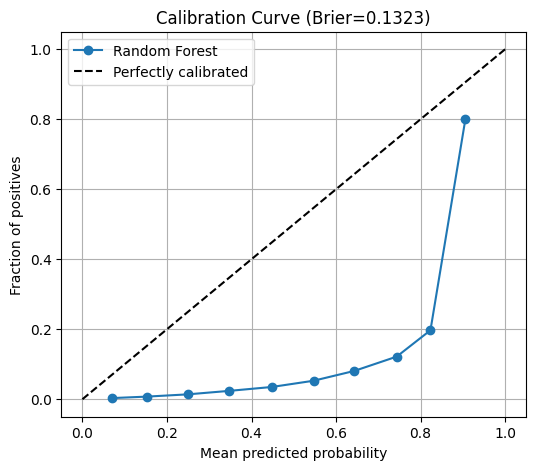

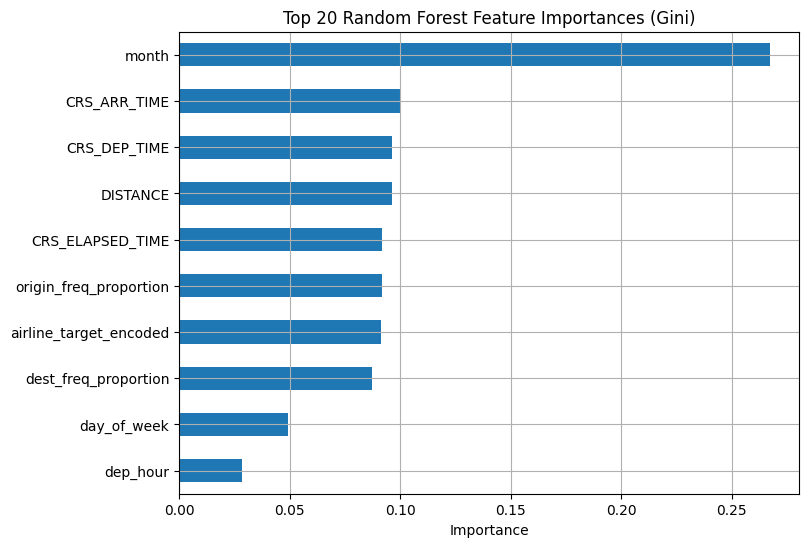

In [48]:
# Model sanity & reliability checks

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# --- Calibration curve ---
# "When the model says 30%, is it actually ~30%?"
prob_true, prob_pred = calibration_curve(y_test, rf_proba, n_bins=10, strategy='uniform')
brier = brier_score_loss(y_test, rf_proba)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration Curve (Brier={brier:.4f})')
plt.grid(True)
plt.legend()
plt.show()

# --- Feature importance (Gini importance) ---
# Caveat: can be biased when features are correlated / have many possible split points.
importances = pd.Series(rf_model.feature_importances_, index=X_train_processed.columns).sort_values(ascending=False)

top_k = 20
plt.figure(figsize=(8, 6))
importances.head(top_k).sort_values().plot(kind='barh')
plt.title(f'Top {top_k} Random Forest Feature Importances (Gini)')
plt.xlabel('Importance')
plt.grid(True)
plt.show()

A calibration analysis indicates that the Random Forest has predicted probabilities **much larger** than the actual observed cancellation rates, suggesting the model is **overconfident**. Feature importance analysis shows that the **month feature is the dominant contributor** to model predictions, which aligns with intuition since certain months may see harsher weather conditions. But it is interesting to note that this feature is significantly more dominant than all other features. **No evidence of target leakage** or implausible feature reliance was observed.